# Lab | Making predictions with logistic regression

In this lab, you will be using the [Sakila](https://dev.mysql.com/doc/sakila/en/) database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.


### Instructions

1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005.
2. Create a query to get the list of films and a boolean indicating if it was rented last month (May 2005). This would be our target variable.
3. Read the data into a Pandas dataframe.
4. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.
5. Create a logistic regression model to predict this variable from the cleaned data.
6. Evaluate the results.


## Import libraries and get database password

In [90]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

## Get database data through sql

In [55]:
# get the data
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''select f.film_id, f.title, f.release_year, f.language_id,
       f.original_language_id, f.rental_rate, f.length, f.rating,f.rental_duration,
       f.replacement_cost,
       l.name as 'language',
       c.name as 'category', r.rental_date, p.amount from film f
left join inventory i on f.film_id=i.film_id
left join film_category fc on f.film_id=fc.film_id
left join category c on c.category_id=fc.category_id
left join language l on l.language_id=f.language_id
left join rental r on r.inventory_id=i.inventory_id
left join payment p on p.rental_id=r.rental_id
ORDER BY f.film_id ASC;'''

sakila = pd.read_sql_query(query, engine)
sakila.head()

,film_id,title,release_year,language_id,original_language_id,rental_rate,length,rating,rental_duration,replacement_cost,language,category,rental_date,amount
0,1,ACADEMY DINOSAUR,2006,1,None,0.99,86,PG,6,20.99,English,Documentary,2005-07-08 19:03:15,0.99
1,1,ACADEMY DINOSAUR,2006,1,None,0.99,86,PG,6,20.99,English,Documentary,2005-08-02 20:13:10,3.99
2,1,ACADEMY DINOSAUR,2006,1,None,0.99,86,PG,6,20.99,English,Documentary,2005-08-21 21:27:43,3.99
3,1,ACADEMY DINOSAUR,2006,1,None,0.99,86,PG,6,20.99,English,Documentary,2005-05-30 20:21:07,1.99
4,1,ACADEMY DINOSAUR,2006,1,None,0.99,86,PG,6,20.99,English,Documentary,2005-06-17 20:24:00,0.99


In [42]:
# define a function for the target

In [56]:
def check_rental(text):
        if '2005-05' in str(text):
            return 'rented'
        else:
            return 'not rented'
        
sakila["rental_status"] = sakila['rental_date'].apply(lambda x: check_rental(x))

In [57]:
sakila["rental_status"].head()

0    not rented
1    not rented
2    not rented
3        rented
4    not rented
Name: rental_status, dtype: object

In [58]:
sakila.head()

,film_id,title,release_year,language_id,original_language_id,rental_rate,length,rating,rental_duration,replacement_cost,language,category,rental_date,amount,rental_status
0,1,ACADEMY DINOSAUR,2006,1,None,0.99,86,PG,6,20.99,English,Documentary,2005-07-08 19:03:15,0.99,not rented
1,1,ACADEMY DINOSAUR,2006,1,None,0.99,86,PG,6,20.99,English,Documentary,2005-08-02 20:13:10,3.99,not rented
2,1,ACADEMY DINOSAUR,2006,1,None,0.99,86,PG,6,20.99,English,Documentary,2005-08-21 21:27:43,3.99,not rented
3,1,ACADEMY DINOSAUR,2006,1,None,0.99,86,PG,6,20.99,English,Documentary,2005-05-30 20:21:07,1.99,rented
4,1,ACADEMY DINOSAUR,2006,1,None,0.99,86,PG,6,20.99,English,Documentary,2005-06-17 20:24:00,0.99,not rented


In [59]:
sakila.columns

Index(['film_id', 'title', 'release_year', 'language_id',
       'original_language_id', 'rental_rate', 'length', 'rating',
       'rental_duration', 'replacement_cost', 'language', 'category',
       'rental_date', 'amount', 'rental_status'],
      dtype='object')

In [60]:
sakila.isna().sum()

film_id                     0
title                       0
release_year                0
language_id                 0
original_language_id    16087
rental_rate                 0
length                      0
rating                      0
rental_duration             0
replacement_cost            0
language                    0
category                    0
rental_date                43
amount                     43
rental_status               0
dtype: int64

In [61]:
sakila.drop(axis=1, columns=['film_id', 'title', 'release_year','rental_date','language_id','original_language_id'], inplace=True)
sakila.isna().sum()

rental_rate          0
length               0
rating               0
rental_duration      0
replacement_cost     0
language             0
category             0
amount              43
rental_status        0
dtype: int64

In [62]:
sakila=sakila.fillna(0)

In [63]:
# should categorized categorized
sakila['rental_rate'].value_counts()

0.99    5668
4.99    5288
2.99    5131
Name: rental_rate, dtype: int64

In [64]:
# bining the movies. 0,90,120,180-max
sakila['length'].value_counts()

85     305
112    244
84     216
178    209
92     196
      ... 
94      43
55      42
72      42
66      22
96      20
Name: length, Length: 140, dtype: int64

In [65]:
# should be categorized
sakila['rental_duration'].value_counts()

3    3418
6    3402
4    3260
5    3170
7    2837
Name: rental_duration, dtype: int64

In [66]:
# should be categorized --- probably gonna drop this one
sakila['replacement_cost'].value_counts()

22.99    1045
27.99     960
21.99     912
29.99     869
12.99     867
20.99     866
14.99     824
13.99     808
11.99     751
25.99     742
26.99     738
10.99     723
28.99     717
18.99     698
17.99     692
23.99     691
9.99      685
19.99     662
16.99     641
24.99     634
15.99     562
Name: replacement_cost, dtype: int64

In [67]:
sakila.dtypes

rental_rate         float64
length                int64
rating               object
rental_duration       int64
replacement_cost    float64
language             object
category             object
amount              float64
rental_status        object
dtype: object

In [68]:
sakila.head()

,rental_rate,length,rating,rental_duration,replacement_cost,language,category,amount,rental_status
0,0.99,86,PG,6,20.99,English,Documentary,0.99,not rented
1,0.99,86,PG,6,20.99,English,Documentary,3.99,not rented
2,0.99,86,PG,6,20.99,English,Documentary,3.99,not rented
3,0.99,86,PG,6,20.99,English,Documentary,1.99,rented
4,0.99,86,PG,6,20.99,English,Documentary,0.99,not rented


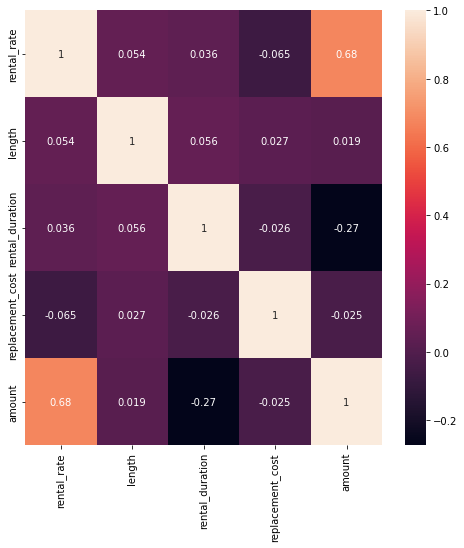

In [73]:
corr_matrix=sakila.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [76]:
sakila['rental_rate'] = sakila['rental_rate'].astype(object)

# converting columns to object

In [77]:
lbl = ['short', 'normal', 'long', 'extended'] 
sakila['length'] = pd.cut(sakila['length'],[0,90,120,150,int(sakila['length'].max())], labels=lbl) 
sakila['length'].value_counts()

# making bins for length 0,90,120,150-max

short       5251
extended    3733
long        3584
normal      3519
Name: length, dtype: int64

In [78]:
sakila['length'] = sakila['length'].astype(object)

In [96]:
sakila.dtypes

rental_rate          object
length               object
rating               object
rental_duration       int64
replacement_cost    float64
language             object
category             object
amount              float64
rental_status        object
dtype: object

# starting the regression analysis

In [97]:
# X-y Split
X = sakila.drop(['rental_status'], axis=1)
y = sakila['rental_status']
    
# Train test Splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [98]:
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((12869, 8), (3218, 8), (12869,), (3218,))

In [99]:
X_train.head()

,rental_rate,length,rating,rental_duration,replacement_cost,language,category,amount
5331,2.99,short,NC-17,6,25.99,English,Games,2.99
1183,4.99,extended,PG,4,18.99,English,Music,6.99
11998,0.99,normal,PG-13,4,16.99,English,Action,0.99
12581,2.99,normal,PG,5,22.99,English,Travel,3.99
7517,2.99,normal,PG,4,21.99,English,Sports,2.99


In [100]:
y_train.head()

5331     not rented
1183     not rented
11998    not rented
12581    not rented
7517     not rented
Name: rental_status, dtype: object

In [101]:
X_train_num = X_train.select_dtypes(include = np.number)
X_train_num.shape

(12869, 3)

In [102]:
#MinMaxScaling

from sklearn.preprocessing import MinMaxScaler

X_train_num = X_train.select_dtypes(include = np.number)

transformer = MinMaxScaler().fit(X_train_num) 
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized, columns=X_train_num.columns) 
X_train_norm.head()

,rental_duration,replacement_cost,amount
0,0.75,0.80,0.249374
1,0.25,0.45,0.582986
2,0.25,0.35,0.082569
3,0.50,0.65,0.332777
4,0.25,0.60,0.249374


In [103]:
X_train_norm.shape

(12869, 3)

In [105]:
X_test_num = X_test.select_dtypes(include = np.number)

X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized, columns=X_test_num.columns) 
X_test_norm.head()

,rental_duration,replacement_cost,amount
0,1.00,0.60,0.332777
1,0.00,0.20,0.666389
2,0.75,0.95,0.082569
3,0.50,0.15,0.582986
4,1.00,0.55,0.082569


In [106]:
X_test_norm.shape

(3218, 3)

In [107]:
from sklearn.preprocessing import OneHotEncoder

X_train_categorical = X_train.select_dtypes(include = object)

encoder = OneHotEncoder(drop='first').fit(X_train_categorical) 
cols=encoder.get_feature_names_out(input_features=X_train_categorical.columns)
encoded = encoder.transform(X_train_categorical).toarray()
X_train_cat = pd.DataFrame(encoded,columns=cols)


In [108]:
X_train_cat.shape

(12869, 24)

In [109]:
X_test_categorical = X_test.select_dtypes(include = object)

cols=encoder.get_feature_names_out(input_features=X_test_categorical.columns)
encoded = encoder.transform(X_test_categorical).toarray()
X_test_cat = pd.DataFrame(encoded,columns=cols)

In [110]:
X_test_cat.shape

(3218, 24)

In [ ]:
# Concat the numerical and categoricals after transformation

In [ ]:
X_train_transformed = np.concatenate([X_train_norm, X_train_cat], axis=1)

In [ ]:
X_test_transformed = np.concatenate([X_test_norm, X_test_cat], axis=1)

In [112]:
# time for regression analysis

from sklearn.linear_model import LogisticRegression

classification = LogisticRegression(solver='saga').fit(X_train_transformed, y_train)
predictions = classification.predict(X_test_transformed)
classification.score(X_test_transformed, y_test)

0.9275947793660658

In [113]:
pd.Series(y_test).value_counts()

not rented    2985
rented         233
Name: rental_status, dtype: int64

In [114]:
pd.Series(predictions).value_counts()
# overchoosing-emphasizing problem here

not rented    3218
dtype: int64

In [115]:
# trying KNN classifier as a second model and see if it give more accuracy
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=4, weights='uniform')
clf.fit(X_train_transformed, y_train)
predictions_clf = clf.predict(X_test_transformed)
clf.score(X_test_transformed, y_test)


0.9272840273461778

In [116]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions_clf)

array([[2984,    1],
       [ 233,    0]])

In [117]:
pd.Series(y_test).value_counts()

not rented    2985
rented         233
Name: rental_status, dtype: int64

In [118]:
pd.Series(predictions_clf).value_counts()
# not sure which model is more accurate KNN or SAGA

not rented    3217
rented           1
dtype: int64

# 1.0.2  Bonus: Validation with June 2005 data 

In [119]:
query_june = '''select f.film_id, f.title, f.release_year, f.language_id,
       f.original_language_id, f.rental_rate, f.length, f.rating,f.rental_duration,
       f.replacement_cost,
       l.name as 'language',
       c.name as 'category', r.rental_date, p.amount from film f
left join inventory i on f.film_id=i.film_id
left join film_category fc on f.film_id=fc.film_id
left join category c on c.category_id=fc.category_id
left join language l on l.language_id=f.language_id
left join rental r on r.inventory_id=i.inventory_id
left join payment p on p.rental_id=r.rental_id
ORDER BY f.film_id ASC;'''

sakila_june = pd.read_sql_query(query_june, engine)
sakila_june.head()

,film_id,title,release_year,language_id,original_language_id,rental_rate,length,rating,rental_duration,replacement_cost,language,category,rental_date,amount
0,1,ACADEMY DINOSAUR,2006,1,None,0.99,86,PG,6,20.99,English,Documentary,2005-07-08 19:03:15,0.99
1,1,ACADEMY DINOSAUR,2006,1,None,0.99,86,PG,6,20.99,English,Documentary,2005-08-02 20:13:10,3.99
2,1,ACADEMY DINOSAUR,2006,1,None,0.99,86,PG,6,20.99,English,Documentary,2005-08-21 21:27:43,3.99
3,1,ACADEMY DINOSAUR,2006,1,None,0.99,86,PG,6,20.99,English,Documentary,2005-05-30 20:21:07,1.99
4,1,ACADEMY DINOSAUR,2006,1,None,0.99,86,PG,6,20.99,English,Documentary,2005-06-17 20:24:00,0.99


In [ ]:
!git add . 
!git commit -m 'Complete'
!